In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [2]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = 2023     # t_ref = T0_AB

e_B = 0.805
i_B = np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)
T0_B = 48707.5
P_B = 314.86
mean_B = np.radians(360*(t_ref - T0_B)/P_B)

e_A = 0.4808
i_A = np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)
T0_A = 48742.5
P_A = 264.51
mean_A = np.radians(360*(t_ref - T0_A)/P_A)

e_AB = 0.46
i_AB = np.radians(88.1)
a_AB = 51
m_A = 1.1
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)
T0_AB = 2023
P_AB = 230
mean_AB = np.radians(360*(t_ref - T0_AB)/P_AB)


# Disk parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disk = 0.03
pos_disk = np.radians(15.6)
inc_disk = np.radians(26)
omega_disk = np.radians(-73)
b_inner = a_inner*np.cos(inc_disk)*(1-e_disk**2)**0.5
b_outer = a_outer*np.cos(inc_disk)*(1-e_disk**2)**0.5


In [3]:
# Create system B (Ba + Bb)

sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Msun')


Ba = rebound.Particle(simulation=sim,
                      m=m_Ba,
                     )


Bb = rebound.Particle(simulation=sim,
                      primary=Ba,
                      m=m_Bb,
                      a=a_B,
                      e=e_B,
                      omega=omega_Bb,
                      inc=i_B,
                      Omega=Omega_B,
                      M=mean_B
                     )


sim.add(Ba)
sim.add(Bb)
sim.move_to_com()
Ba, Bb = sim.particles


# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB,
                     M=mean_AB
                    )

# Create system AaAb and shift to CoM reference frame

sim_A = rebound.Simulation()
sim_A.units = ('days', 'AU', 'Msun')


Ab = rebound.Particle(simulation=sim_A,
                      m=m_Ab,
                     )

Aa = rebound.Particle(simulation=sim_A,
                      primary=Ab,
                      m=m_Aa,
                      a=a_A,
                      e=e_A,
                      omega=omega_Aa,
                      inc=i_A,
                      Omega=Omega_A,
                      M=mean_A
                     )


sim_A.add(Aa)
sim_A.add(Ab)
sim_A.move_to_com()
Aa_A, Ab_A = sim_A.particles      # Aa and Ab in the A CoM reference frame


# Shift Aa and Ab into the system B CoM reference frame

def change_reference_frames(star, ref):
    # ref = old reference frame in the new reference frame
    # star = star in the old reference frame
    ref_v = np.array([ref.vx, ref.vy, ref.vz])                            # velocity of current reference frame in the new reference frame
    v_in_ref = np.array([star.vx, star.vy, star.vz])                      # velocity of star in current reference frame
    v = v_in_ref + ref_v                                                  # velocity of star in the new reference frame
    
    ref_pos = np.array([ref.x, ref.y, ref.z])                             # position of current reference frame in the new reference frame
    pos_in_ref = np.array([star.x, star.y, star.z])                       # position of star in current reference frame
    pos = pos_in_ref + ref_pos                                            # position of star in the new reference frame
    
    return pos,v

pos_Aa, v_Aa = change_reference_frames(Aa_A, A)
pos_Ab, v_Ab = change_reference_frames(Ab_A, A)

def generate_cartesian_particle(m, pos, v):
    x, y, z = pos
    vx, vy, vz = v
    return rebound.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)

Aa = generate_cartesian_particle(m_Aa, pos_Aa, v_Aa)
Ab = generate_cartesian_particle(m_Ab, pos_Ab, v_Ab)

sim.add(Aa)
sim.add(Ab)



In [4]:
sim.getWidget(orbits=True)

Widget(N=4, count=2, height=200.0, orbit_data=b'\xc41\x8b>n\xf6\xaa\xbeE\xc6\n\xbf\xaeG\x81?{\x14N?\xda\xbd[@\…

In [5]:
# Plot orbits

start_time = 0
t_max = 18*365.25 + start_time   # integrate over 18 years
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_Aa, y_Aa, z_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)  
x_Ab, y_Ab, z_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps) 
x_Ba, y_Ba, z_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Bb, y_Bb, z_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


vx_Aa, vy_Aa, vz_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ab, vy_Ab, vz_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ba, vy_Ba, vz_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Bb, vy_Bb, vz_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


Ba, Bb, Aa, Ab = sim.particles

for i, t in enumerate(times):
    sim.integrate(t)

    # Calculate the CoM of Ba and Bb
    comB = sim.calculate_com(first=0, last=2)     
    pos_comB = np.array([comB.x, comB.y, comB.z])
    v_comB = np.array([comB.vx, comB.vy, comB.vz])
    
    # Recenter all components so the CoM of BaBb is at the origin
    x_Ba[i], y_Ba[i], z_Ba[i] = np.array([Ba.x, Ba.y, Ba.z]) - pos_comB
    x_Bb[i], y_Bb[i], z_Bb[i] = np.array([Bb.x, Bb.y, Bb.z]) - pos_comB
    vx_Ba[i], vy_Ba[i], vz_Ba[i] = np.array([Ba.vx, Ba.vy, Ba.vz]) - v_comB
    vx_Bb[i], vy_Bb[i], vz_Bb[i] = np.array([Bb.vx, Bb.vy, Bb.vz]) - v_comB
    
    x_Aa[i], y_Aa[i], z_Aa[i] = np.array([Aa.x, Aa.y, Aa.z]) - pos_comB
    x_Ab[i], y_Ab[i], z_Ab[i] = np.array([Ab.x, Ab.y, Ab.z]) - pos_comB
    vx_Aa[i], vy_Aa[i], vz_Aa[i] = np.array([Aa.vx, Aa.vy, Aa.vz]) - v_comB
    vx_Ab[i], vy_Ab[i], vz_Ab[i] = np.array([Ab.vx, Ab.vy, Ab.vz]) - v_comB
       
    
    

<IPython.core.display.Javascript object>


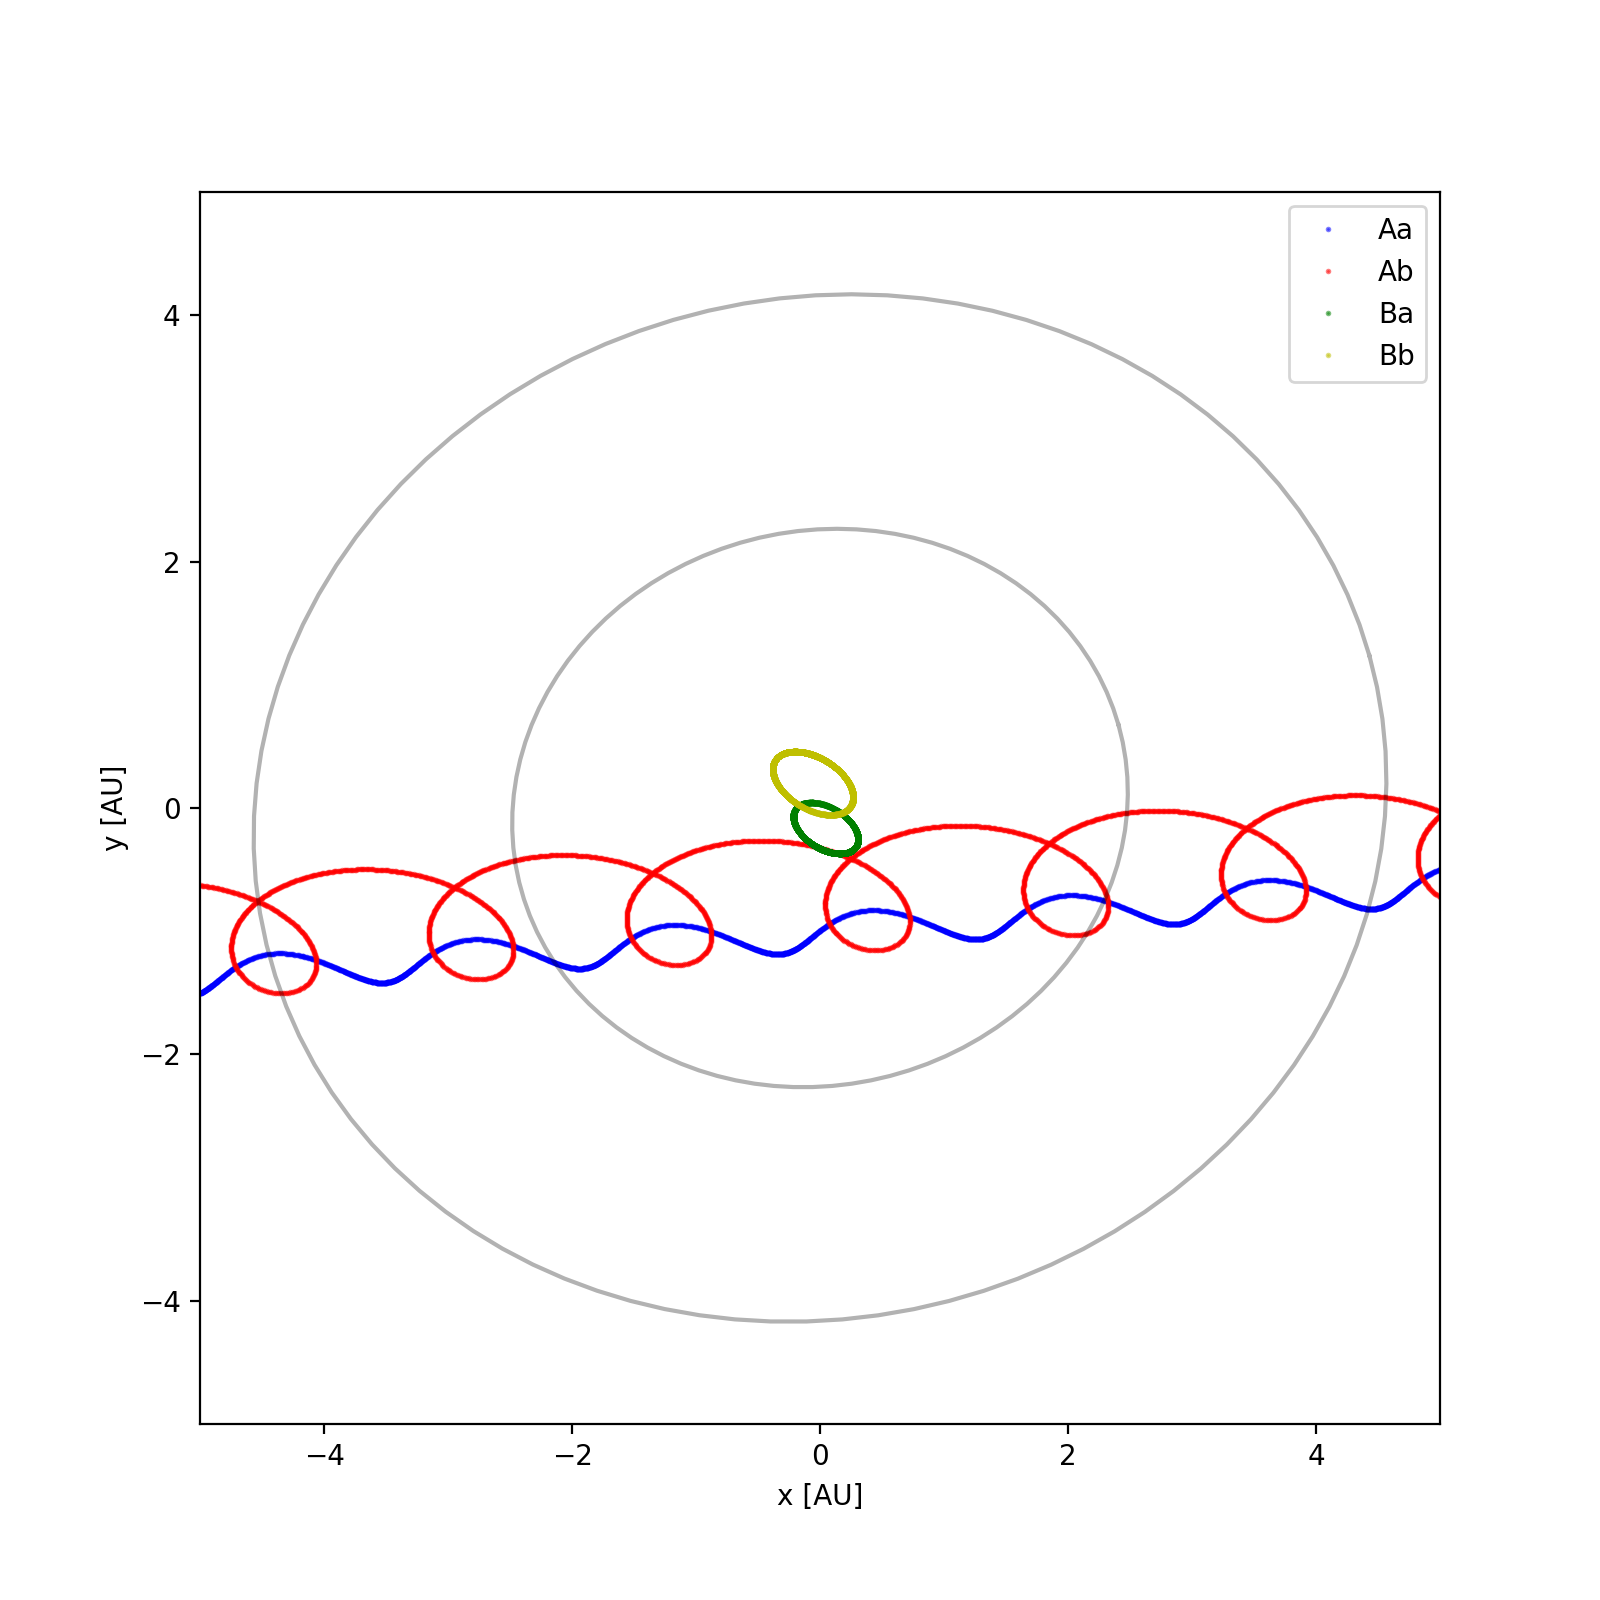

In [6]:
# Build disk

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disk)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disk)

# Rotate disk
x_o = x_outer*np.cos(pos_disk) - y_outer*np.sin(pos_disk)
y_o = x_outer*np.sin(pos_disk) + y_outer*np.cos(pos_disk)
x_i = x_inner*np.cos(pos_disk) - y_inner*np.sin(pos_disk)
y_i = x_inner*np.sin(pos_disk) + y_inner*np.cos(pos_disk)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

# Make 2D plot
fig = plt.figure(figsize=(8,8))

plt.plot(x_Aa, y_Aa, 'b.', alpha = 0.5, markersize=2, label='Aa')
plt.plot(x_Ab, y_Ab, 'r.', alpha = 0.5, markersize=2, label='Ab')
plt.plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=2, label='Ba')
plt.plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=2, label='Bb')

plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()


# # 3D Plot
# ax = fig.add_subplot(111, projection='3d')

# # Plot binary orbits relative to the  CoM of BaBb
# ax.plot(x_Aa, y_Aa, z_Aa, 'b.', alpha = 0.5, label='Aa', markersize=2)
# ax.plot(x_Ab, y_Ab, z_Ab, 'r.', alpha = 0.5, label='Ab', markersize=2)
# ax.plot(x_Ba, y_Ba, z_Ba, 'g.', alpha = 0.5, label='Ba', markersize=1)
# ax.plot(x_Bb, y_Bb, z_Bb, 'c.', alpha = 0.5, label='Bb', markersize=1)

# # Plot disk in 3D
# ax.plot(x_outer, y_outer, z_outer, 'k', alpha=0.3)
# ax.plot(x_inner, y_inner, z_inner, 'k', alpha=0.3)

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.legend()






In [33]:
sim.getWidget()

Widget(N=4, count=2, height=200.0, orbit_data=b'\xb9#\x9d\xc0\x8e\xbc\x84\xbf\r\xc6\xe5@IF\x81??\xeaM?\xceGQ@\…